In [1]:
import requests
import numpy as np
import h5py
import matplotlib.pyplot as plt

import MAS_library as pylians_MASL
import smoothing_library as pylians_SL

import astropy.cosmology
from astropy import units as u
from astropy import constants as const



%matplotlib inline

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"9af02c30810f12be44f17ad2bd4b6510"}

sim_name = 'TNG100-1-Dark'
redshift = 0.0
base_query = f'/api/{sim_name}/snapshots/z={redshift}/'

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r



# Cosmology

In [2]:

sim = get('http://www.tng-project.org/api/TNG100-1-Dark')
snapshot = get('http://www.tng-project.org/api/TNG100-1-Dark/snapshots/z=0.0/')


z = snapshot['redshift']
Omega_0 = sim['omega_0']
omega_B = sim['omega_B']
h = sim['hubble']

dm_mass = sim['mass_dm']


cosmo = astropy.cosmology.FlatLambdaCDM(H0=h*100, Om0=Omega_0, Ob0=omega_B) #also astropy.cosmology.Planck15 but its a bit different
#mean_density = cosmo.critical_density(z).to('Msun/Mpc^3').value
mean_density = cosmo.critical_density(z)

# Counting haloes for a list of conditions

In [19]:
# first convert log solar masses into group catalog units
mass_min = 10**11 / 1e10 * 0.704
mass_max = 10**15 / 1e10 * 0.704

# form the search_query string by hand for once
search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max) +'&primary_flag__gt=0.9'+'&len__gr=150'

url = 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/z=0.0/'+"subhalos/" + search_query
subhalos_all = get(url, {'limit':20000})
print(f"{subhalos_all['count']} halos with search criteria \n \t {search_query}")



#get random 10 halos
np.random.seed(0)

random_idx = np.random.choice(subhalos_all['count'], 3, replace=False)
random_idx = list(random_idx) + [1] #4 minites to download snap 24681, 1.27 gb, DM coords + density

#select 10 indices from 0 to count uniformly

#random_idx = np.random.choice(subhalos_all['count'], 10, replace=False)

subhalos = [subhalos_all['results'][i] for i in random_idx]

subhalos = {sh['id']:sh['url'] for sh in subhalos}


16544 halos with search criteria 
 	 ?mass__gt=7.039999999999999&mass__lt=70400.0&primary_flag__gt=0.9&len__gr=150


In [33]:
len(subhalos_all['results'])

16544

In [21]:
subhalos

{574424: 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/99/subhalos/574424/',
 818916: 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/99/subhalos/818916/',
 912055: 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/99/subhalos/912055/',
 24681: 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/99/subhalos/24681/'}

---

In [24]:
id = 24681
url = subhalos[id]
sub_prog = get(url)

#cutout_request = {'dm':'Coordinates,SubfindDMDensity'}
cutout_request = {'dm':'Coordinates'}
cutout = get(url+"cutout.hdf5", cutout_request)


In [25]:
cutout

'cutout_24681.hdf5'

In [ ]:
#def get_dm(id):
if True:
    id = 24681
    url = subhalos[id]
    sub_prog = get(url)

    cutout_request = {'dm':'Coordinates,Potential'}
    cutout = get(url+"cutout.hdf5", cutout_request)



    with h5py.File(cutout,'r') as f:
        #file attributes: https://www.tng-project.org/data/docs/specifications/

        #center coord
        center = np.array([sub_prog['pos_x'], sub_prog['pos_y'], sub_prog['pos_z']])


        x = f['PartType1']['Coordinates'][:,0]
        y = f['PartType1']['Coordinates'][:,1]
        z = f['PartType1']['Coordinates'][:,2]


    sublink_tree = sub_prog['trees']['sublink']


    with h5py.File(sublink_tree,'r') as f:
        pass

        

In [28]:
f = h5py.File(cutout,'r')

In [29]:
        x = f['PartType1']['Coordinates'][:,0]
        y = f['PartType1']['Coordinates'][:,1]
        z = f['PartType1']['Coordinates'][:,2]


In [75]:
sub_prog

{'snap': 99,
 'id': 818916,
 'cm_x': 10618.5,
 'cm_y': 28002.0,
 'cm_z': 61688.2,
 'pos_x': 10616.9,
 'pos_y': 27999.6,
 'pos_z': 61701.3,
 'halfmassrad': 44.3249,
 'len': 37524,
 'mass': 22.5132,
 'massinhalfrad': 0.0,
 'massinmaxrad': 5.25633,
 'massinrad': 0.0,
 'spin_x': -1134.69,
 'spin_y': -125.066,
 'spin_z': -210.077,
 'vel_x': 41.3855,
 'vel_y': 179.707,
 'vel_z': -129.54,
 'veldisp': 62.8111,
 'vmax': 111.017,
 'vmaxrad': 18.3489,
 'prog_snap': 98,
 'prog_sfid': 817639,
 'desc_snap': -1,
 'desc_sfid': -1,
 'fp_match_sfid': 588196,
 'parent': 0,
 'grnr': 5172,
 'primary_flag': 1,
 'mass_log_msun': 11.521592037190764,
 'related': {'sublink_progenitor': 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/98/subhalos/817639/',
  'sublink_descendant': None,
  'parent_halo': 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/99/halos/5172/'},
 'cutouts': {'subhalo': 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/99/subhalos/818916/cutout.hdf5',
  'parent_halo': 'h

In [59]:
sublink = h5py.File('sublink_818916.hdf5','r')

In [61]:
sublink.keys()

<KeysViewHDF5 ['DescendantID', 'FirstProgenitorID', 'FirstSubhaloInFOFGroupID', 'GroupCM', 'GroupFirstSub', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupPos', 'GroupVel', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200', 'LastProgenitorID', 'MainLeafProgenitorID', 'Mass', 'MassHistory', 'NextProgenitorID', 'NextSubhaloInFOFGroupID', 'NumParticles', 'RootDescendantID', 'SnapNum', 'SubfindID', 'SubhaloCM', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloID', 'SubhaloIDMostbound', 'SubhaloIDRaw', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSpin', 'SubhaloVel', 'SubhaloVelDisp', 'SubhaloVmax', 'SubhaloVmaxRad', 'TreeID']>

In [74]:
sublink['SubhaloCM'][:]

array([[10618.455 , 28001.982 , 61688.156 ],
       [10614.1455, 27984.24  , 61702.07  ],
       [10607.663 , 27957.469 , 61722.08  ],
       ...,
       [ 9019.456 , 25209.607 , 62200.285 ],
       [ 8982.454 , 25166.148 , 62176.49  ],
       [ 8944.489 , 25127.344 , 62164.785 ]], dtype=float32)

In [79]:
(sublink['SubhaloCM'][:][:,0]==10618.5).sum()

0

In [80]:
sublink['SubfindID'][:]

array([ 818916,  817639,  814806, ..., 3205551, 3973972, 4174349],
      dtype=int32)

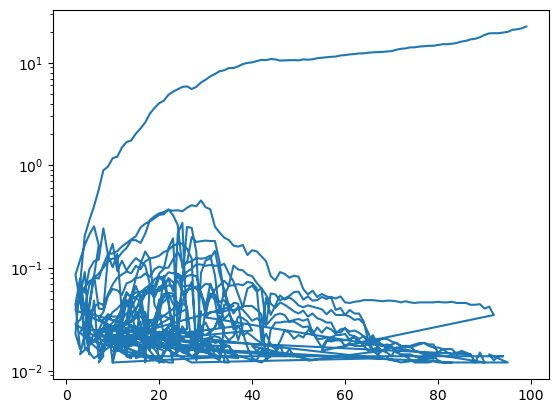

In [71]:
m = sublink['SubhaloMass'][:]
s = sublink['SnapNum'][:]

plt.semilogy(s,m)

In [67]:
len(m)

1114